Entry: /usr/local/share/pynq-venv/lib/python3.8/site-packages/ipykernel_launcher.py
System argument(s): 3
Start of "/usr/local/share/pynq-venv/lib/python3.8/site-packages/ipykernel_launcher.py"
Kernel execution time: 0.002017498016357422 s


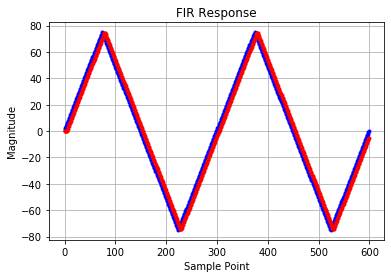

Exit process


In [2]:

# coding: utf-8

# In[3]:


from __future__ import print_function

import sys, os
import numpy as np
from time import time
import matplotlib.pyplot as plt 

sys.path.append('/home/xilinx')
os.environ['XILINX_XRT'] = '/usr'
from pynq import Overlay
from pynq import allocate

if __name__ == "__main__":
    print("Entry:", sys.argv[0])
    print("System argument(s):", len(sys.argv))

    print("Start of \"" + sys.argv[0] + "\"")

    ol = Overlay("/home/xilinx/jupyter_notebooks/FIRN11Stream.bit")
    ipFIRN11 = ol.fir_n11_strm_0
    ipDMAIn = ol.axi_dma_in_0
    ipDMAOut = ol.axi_dma_out_1

    fiSamples = open("samples_triangular_wave.txt", "r+")
    numSamples = 0
    line = fiSamples.readline()
    while line:
        numSamples = numSamples + 1
        line = fiSamples.readline()

    inBuffer0 = allocate(shape=(numSamples,), dtype=np.int32)
    outBuffer0 = allocate(shape=(numSamples,), dtype=np.int32)
    fiSamples.seek(0)
    for i in range(numSamples):
        line = fiSamples.readline()
        inBuffer0[i] = int(line)
    fiSamples.close()

    numTaps = 11
    n32Taps = [0, -10, -9, 23, 56, 63, 56, 23, -9, -10, 0]
    #n32Taps = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
    n32DCGain = 0
    timeKernelStart = time()
    for i in range(numTaps):
        n32DCGain = n32DCGain + n32Taps[i]
        ipFIRN11.write(0x40 + i * 4, n32Taps[i])
    if n32DCGain < 0:
        n32DCGain = 0 - n32DCGain
    ipFIRN11.write(0x10, len(inBuffer0) * 4)
    ipFIRN11.write(0x00, 0x01)
    ipDMAIn.sendchannel.transfer(inBuffer0)
    ipDMAOut.recvchannel.transfer(outBuffer0)
    ipDMAIn.sendchannel.wait()
    ipDMAOut.recvchannel.wait()
    timeKernelEnd = time()
    print("Kernel execution time: " + str(timeKernelEnd - timeKernelStart) + " s")
      
    plt.title("FIR Response")
    plt.xlabel("Sample Point") 
    plt.ylabel("Magnitude")
    xSeq = range(len(inBuffer0))
    if n32DCGain == 0:
        plt.plot(xSeq, inBuffer0, 'b.', xSeq, outBuffer0, 'r.')
    else:
        plt.plot(xSeq, inBuffer0, 'b.', xSeq, outBuffer0 / n32DCGain, 'r.')
    plt.grid(True)
    plt.show() # In Jupyter, press Tab + Shift keys to show plot then redo run

    print("============================")
    print("Exit process")

